In [59]:
import ee
import geemap
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

In [4]:
manaus_shp = '/Users/morgansteckler/Desktop/tile_shapefiles/venus_fgmanaus_footprint/venus_fgmanaus_footprint.shp'
#manaus_shp = '/home/6ru/tile_shapefiles/manaus/venus_fgmanaus_footprint.shp'
manaus = geemap.shp_to_ee(manaus_shp)
info = manaus.geometry()
manaus = ee.Geometry(info)

In [5]:
atto_shp = '/Users/morgansteckler/Desktop/tile_shapefiles/venus_atto_footprint/venus_atto_footprint.shp'
#atto_shp = '/home/6ru/tile_shapefiles/atto/venus_atto_footprint.shp'
atto = geemap.shp_to_ee(atto_shp)
info = atto.geometry()
atto = ee.Geometry(info)

In [49]:
corumba_shp = '/Users/morgansteckler/Desktop/tile_shapefiles/venus_corumba_footprint/venus_corumba_footprint.shp'
#corumba_shp = '/home/6ru/tile_shapefiles/corumba/venus_corumba_footprint.shp'
corumba = geemap.shp_to_ee(corumba_shp)
info = corumba.geometry()
corumba = ee.Geometry(info)

In [7]:
mato_shp = '/Users/morgansteckler/Desktop/tile_shapefiles/venus_mato_footprint/venus_mato_footprint.shp'
#mato_shp = '/home/6ru/tile_shapefiles/mato/venus_mato_footprint.shp'
mato = geemap.shp_to_ee(mato_shp)
info = mato.geometry()
mato = ee.Geometry(info)

In [8]:
saop_shp = '/Users/morgansteckler/Desktop/tile_shapefiles/venus_saop_footprint/venus_saop_footprint.shp'
#saop_shp = '/home/6ru/tile_shapefiles/saop/venus_saop_footprint.shp'
saop = geemap.shp_to_ee(saop_shp)
info = saop.geometry()
saop = ee.Geometry(info)

In [194]:
#IMPORTANT
#Select geom of interest
fc = manaus

In [128]:
Map = geemap.Map()
Map.centerObject(fc, 10)
Map

Map(center=[-2.4396454678431994, -59.78996156231432], controls=(WidgetControl(options=['position'], widget=HBo…

In [172]:
s2 = (ee.ImageCollection('COPERNICUS/S2')
      .filterBounds(fc)
      .select(['B4', 'B3', 'B2'])
      .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 20)
      .filterDate(ee.Date('2016-01-01'), ee.Date('2019-12-31'))
      .sort('CLOUDY_PIXEL_PERCENTAGE', False)
      .median())

In [173]:
s2 = s2.clip(fc)

In [185]:
Map.addLayer(s2, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Manaus')

In [183]:
s2.visualize({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000})
task = ee.batch.Export.image.toDrive(image=s2, description="manaus_rgb", folder="test", scale=40, region=manaus)
task.start()

In [188]:
print(task.status())

{'state': 'RUNNING', 'description': 'manaus_rgb', 'creation_timestamp_ms': 1594772192170, 'update_timestamp_ms': 1594772200741, 'start_timestamp_ms': 1594772200602, 'task_type': 'EXPORT_IMAGE', 'id': '4LM3LFNTUTZOXKXJKRMBM6MM', 'name': 'projects/earthengine-legacy/operations/4LM3LFNTUTZOXKXJKRMBM6MM'}


In [195]:
#Calculate NDRE and set palette
def addNDRE(image):
    ndre = image.normalizedDifference(['B8', 'B5']).rename('NDRE')
    return image.addBands(ndre)

#Set NDRE parameters for visualization
ndre_params = ({'min': 0.0,'max': 1.0, 'palette' : 
               ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
               '74A901', '66A000', '529400', '3E8601', '207401', '056201',
               '004C00', '023B01', '012E01', '011D01', '011301']})

#Create cloud mask
cloudBitMask = ee.Number(2).pow(10).int() #bit 10 is clouds
cirrusBitMask = ee.Number(2).pow(11).int() #bit 11 is cirrus clouds
def maskS2clouds(image):
    qa = image.select('QA60')
    # Both flags should be set to zero, indicating clear conditions.
    mask = (qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0)))
    return image.updateMask(mask)

In [196]:
#Load sentinel-2 data
s2 = (ee.ImageCollection('COPERNICUS/S2')#Select S2 1-C level data
      .select(['B5', 'B8', 'QA60']) #Select necessary bands to reduce memory usage
      .filterBounds(fc) #Narrow data spatially
      .filterDate(ee.Date('2017-01-01'), ee.Date('2018-12-31')) #Select years of interest
      .sort('CLOUDY_PIXEL_PERCENTAGE', False) #Put smallest %cloud image on top of stack
      .map(addNDRE)) #calculate NDRE and add as band

In [197]:
#Create collection with cloud mask
col = s2.map(maskS2clouds)

In [198]:
#15-day step
years = ee.List.sequence(2017, 2018)
step = ee.List.sequence(1, 365, 15)

def byYear(y):
    y = ee.Number(y)
    def byStep(d):
        d = ee.Number(d)
        return (col
                .filter(ee.Filter.calendarRange(y, y.add(1), 'year')) #yearly step
                .filter(ee.Filter.calendarRange(d, d.add(15), 'day_of_year')) #15-day step
                .qualityMosaic('NDRE') #Max greenness
                .set('step', [d, y])) #Add properties
    return step.map(byStep)

col = ee.ImageCollection.fromImages(years.map(byYear).flatten())
col = col.map(lambda image: image.clip(fc)).select('NDRE')

In [199]:
#Makes sure there are 100 (25 15-day steps * 4 years = 100 composites)
count = col.size().getInfo()
print(count)

50


In [71]:
#Check step property
properties = col.aggregate_array('step').getInfo()
print(properties)

[[1, 2017], [16, 2017], [31, 2017], [46, 2017], [61, 2017], [76, 2017], [91, 2017], [106, 2017], [121, 2017], [136, 2017], [151, 2017], [166, 2017], [181, 2017], [196, 2017], [211, 2017], [226, 2017], [241, 2017], [256, 2017], [271, 2017], [286, 2017], [301, 2017], [316, 2017], [331, 2017], [346, 2017], [361, 2017], [1, 2018], [16, 2018], [31, 2018], [46, 2018], [61, 2018], [76, 2018], [91, 2018], [106, 2018], [121, 2018], [136, 2018], [151, 2018], [166, 2018], [181, 2018], [196, 2018], [211, 2018], [226, 2018], [241, 2018], [256, 2018], [271, 2018], [286, 2018], [301, 2018], [316, 2018], [331, 2018], [346, 2018], [361, 2018]]


In [ ]:
#Atto removal: 5, 24
col = (col.filter(ee.Filter.neq('step', [76, 2016])) #5
       .filter(ee.Filter.neq('step', [361, 2016]))) #24

In [109]:
#Saop removal: 9, 24, 99
col = (col.filter(ee.Filter.neq('step', [361, 2019])) #99
       .filter(ee.Filter.neq('step', [361, 2016])) #24
       .filter(ee.Filter.neq('step', [136, 2016]))) #9

In [38]:
#Check step property
properties = col.aggregate_array('step').getInfo()
print(properties)

[[1, 2016], [16, 2016], [31, 2016], [46, 2016], [61, 2016], [76, 2016], [91, 2016], [106, 2016], [121, 2016], [136, 2016], [151, 2016], [166, 2016], [181, 2016], [196, 2016], [211, 2016], [226, 2016], [241, 2016], [256, 2016], [271, 2016], [286, 2016], [301, 2016], [316, 2016], [331, 2016], [346, 2016], [361, 2016], [1, 2017], [16, 2017], [31, 2017], [46, 2017], [61, 2017], [76, 2017], [91, 2017], [106, 2017], [121, 2017], [136, 2017], [151, 2017], [166, 2017], [181, 2017], [196, 2017], [211, 2017], [226, 2017], [241, 2017], [256, 2017], [271, 2017], [286, 2017], [301, 2017], [316, 2017], [331, 2017], [346, 2017], [361, 2017], [1, 2018], [16, 2018], [31, 2018], [46, 2018], [61, 2018], [76, 2018], [91, 2018], [106, 2018], [121, 2018], [136, 2018], [151, 2018], [166, 2018], [181, 2018], [196, 2018], [211, 2018], [226, 2018], [241, 2018], [256, 2018], [271, 2018], [286, 2018], [301, 2018], [316, 2018], [331, 2018], [346, 2018], [361, 2018], [1, 2019], [16, 2019], [31, 2019], [46, 2019], [

In [111]:
#See how many images are left
count = col.size().getInfo()
print(count)

97


In [ ]:
###Stop here for exporting images####

In [200]:
geom = fc

# Mean
def region_mean_Image(img):
    # mean over all pixels in the region for the image
    return img.set('mean', img.reduceRegion(ee.Reducer.mean(), geometry=geom, scale=20)) 

def region_mean_ImageCollection(ic):
    # mean over all pixels in the region, for each image in the ImageCollection
    stats = ic.map(region_mean_Image)
    stats_list = stats.aggregate_array('mean')
    return np.array(stats_list.getInfo())

# Median
def region_median_Image(img):
    # mean over all pixels in the region for the image
    return img.set('median', img.reduceRegion(ee.Reducer.median(), geometry=geom, scale=20)) 

def region_median_ImageCollection(ic):
    # mean over all pixels in the region, for each image in the ImageCollection
    stats = ic.map(region_median_Image)
    stats_list = stats.aggregate_array('median')
    return np.array(stats_list.getInfo())

# Stddev
def region_stddev_Image(img):
    # stddev over all pixels in the region for the image
    return img.set('stddev', img.reduceRegion(ee.Reducer.stdDev(), geometry=geom, scale=20)) 

def region_stddev_ImageCollection(ic):
    # stddev over all pixels in the region, for each image in the ImageCollection
    stats = ic.map(region_stddev_Image)
    stats_list = stats.aggregate_array('stddev')
    return np.array(stats_list.getInfo())

# Percentiles
def region_percentiles_Image(img):
    # 5,10,25,75,90,95 percentiles over all pixels in the region for the image
    return img.set('percentiles', img.reduceRegion(ee.Reducer.percentile([5,10,25,75,90,95]), geometry=geom, scale=20)) #) mean, median, stdDev, percentiles

def region_percentiles_ImageCollection(ic):
    # percentiles over all pixels in the region, for each image in the ImageCollection
    stats = ic.map(region_percentiles_Image)
    stats_list = stats.aggregate_array('percentiles')
    return np.array(stats_list.getInfo())

In [201]:
#Create list of dictionaries as [{'NDRE': value} ...]
mean_list = region_mean_ImageCollection(col)
median_list = region_median_ImageCollection(col)
stddev_list = region_stddev_ImageCollection(col)
percentile_list = region_percentiles_ImageCollection(col)

In [74]:
#Show if there are any blank {} dictionaries
print(mean_list)

[{'NDRE': 0.4264938998095169} {'NDRE': 0.47136539030220487}
 {'NDRE': 0.3787582888339559} {'NDRE': 0.4020423234309646}
 {'NDRE': 0.3671164697713704} {'NDRE': 0.42598560954497405}
 {'NDRE': 0.39425913982146776} {'NDRE': 0.44333313405700064}
 {'NDRE': 0.43142699576741406} {'NDRE': 0.401029892266415}
 {'NDRE': 0.3573500354318259} {'NDRE': 0.3417749290466697}
 {'NDRE': 0.2902734724492054} {'NDRE': 0.25476838559370313}
 {'NDRE': 0.22903814964863523} {'NDRE': 0.22382295752009262}
 {'NDRE': 0.22262165666470016} {'NDRE': 0.2276569176675254}
 {'NDRE': 0.21900790985523588} {'NDRE': 0.25932853597821687}
 {'NDRE': 0.25072755325679397} {'NDRE': 0.3241346792918328}
 {'NDRE': 0.37876709115636736} {'NDRE': 0.4441178064638511}
 {'NDRE': 0.4441139985385805} {'NDRE': 0.2797234603734752}
 {'NDRE': 0.4521688191500623} {'NDRE': 0.34333843078453413}
 {'NDRE': 0.3899345881044914} {'NDRE': 0.3207698581897127}
 {'NDRE': 0.4124939126976172} {'NDRE': 0.37587113274705886}
 {'NDRE': 0.4250837698125082} {'NDRE': 0.4

In [ ]:
#Replace empty dicts with {'NDRE': None}
#Atto: 5, 24
#Saop: 9, 24, 99
dic = {'NDRE': None}
p_dic = {'NDRE_p10': None, 'NDRE_p25': None, 'NDRE_p5': None, 'NDRE_p75': None, 'NDRE_p90': None, 'NDRE_p95': None}
mean_list[5], mean_list[24] = dic, dic
median_list[5], median_list[24] = dic, dic
stddev_list[5], stddev_list[24] = dic, dic
percentile_list[5], percentile_list[24] = p_dic, p_dic

In [202]:
#Take only the ndre mean, med, stddev dict values and append to new list
def newList(alist):
    list_name = []
    for value in alist:
        list_name.append(value['NDRE'])
    return list_name

#Append ndre percentile dict values to new lists
def p_list(alist):
    p10, p25, p5, p75, p90, p95 = [], [], [], [], [], []
    for value in alist:
        p5.append(value['NDRE_p5'])
        p10.append(value['NDRE_p10'])
        p25.append(value['NDRE_p25'])
        p75.append(value['NDRE_p75'])
        p90.append(value['NDRE_p90'])
        p95.append(value['NDRE_p95'])
    return p5, p10, p25, p75, p90, p95

In [203]:
#Make lists for each set of values
mean_ndre = newList(mean_list)
median_ndre = newList(median_list)
stddev_ndre = newList(stddev_list)
percentile_ndre = p_list(percentile_list)

In [204]:
#Change None values to np.nan so graphs will skip those Nulls
mean_ndre = [np.nan if v is None else v for v in mean_ndre]
median_ndre = [np.nan if v is None else v for v in median_ndre]
stddev_ndre = [np.nan if v is None else v for v in stddev_ndre]
percentile_ndre = [np.nan if v is None else v for v in percentile_ndre]

In [205]:
#Make lists with +/- SD
plus_error = [x + y for x,y in zip(mean_ndre, stddev_ndre)]
minus_error = [x - y for x,y in zip(mean_ndre, stddev_ndre)]

In [206]:
#Create 15-step list for four years
period = list(range(0,50))
period = np.array(period)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


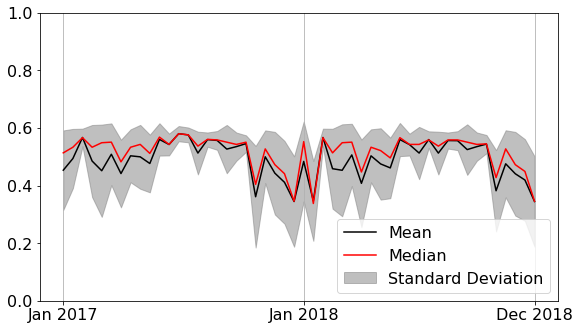

In [208]:
#Manaus
#Mean and SD
x = period
y = mean_ndre
m = median_ndre
plt.axes([2, 0, 1.2, 1])
plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
#plt.title('2016-2019 (15-day step) mean, median, and SD of NDRE for Manaus Tile')
plt.fill_between(x, plus_error, minus_error, color = "grey", alpha = .5, label = "Standard Deviation")
mean = plt.plot(x,y, color = "black", label = "Mean")
median = plt.plot(x,m, color = "red", label = "Median")
plt.legend(loc = "lower right")
plt.xticks(ticks = [0, 25, 49], labels = ['Jan 2017', 'Jan 2018', 'Dec 2018'])

plt.rc('legend', fontsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.show()

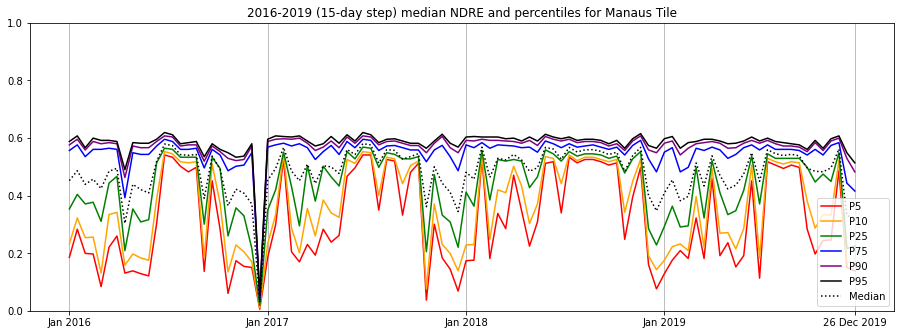

In [48]:
#Manaus
#Median and Percentiles
x = period
plt.axes([2, 0, 2, 1])
plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
y5 = plt.plot(x,percentile_ndre[0], color = "red", label = "P5")
y10 = plt.plot(x,percentile_ndre[1], color = "orange", label = "P10")
y25 = plt.plot(x,percentile_ndre[2], color = "green", label = "P25")
y75 = plt.plot(x,percentile_ndre[3], color = "blue", label = "P75")
y90 = plt.plot(x,percentile_ndre[4], color = "purple", label = "P90")
y95 = plt.plot(x,percentile_ndre[5], color = "black", label = "P95")
plt.title('2016-2019 (15-day step) median NDRE and percentiles for Manaus Tile')
median = plt.plot(x,y, color = "black", linestyle = ":", label = "Median")
plt.legend(loc = "lower right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])
plt.show()

In [ ]:
#Atto
#Mean and SD
x = period
y = mean_ndre
m = median_ndre
plt.axes([2, 0, 2, 1])
plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
plt.title('2016-2019 (15-day step) mean, median, and SD of NDRE for Atto Tile')
plt.fill_between(x, plus_error, minus_error, color = "grey", alpha = .5, label = "Standard Deviation")
mean = plt.plot(x,y, color = "black", label = "Mean")
median = plt.plot(x,m, color = "red", label = "Median")
plt.legend(loc = "lower right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])
plt.show()

In [ ]:
#Atto
#Median and Percentiles
x = period
plt.axes([2, 0, 2, 1])
plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
y5 = plt.plot(x,percentile_ndre[0], color = "red", label = "P5")
y10 = plt.plot(x,percentile_ndre[1], color = "orange", label = "P10")
y25 = plt.plot(x,percentile_ndre[2], color = "green", label = "P25")
y75 = plt.plot(x,percentile_ndre[3], color = "blue", label = "P75")
y90 = plt.plot(x,percentile_ndre[4], color = "purple", label = "P90")
y95 = plt.plot(x,percentile_ndre[5], color = "black", label = "P95")
plt.title('2016-2019 (15-day step) median NDRE and percentiles for Atto Tile')
median = plt.plot(x,m, color = "black", linestyle = ":", label = "Median")
plt.legend(loc = "lower right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])
plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


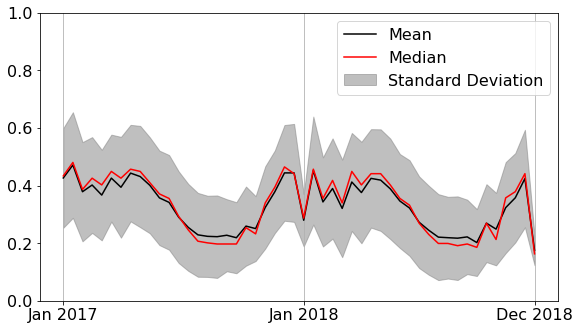

In [126]:
#Corumba
#Mean and SD
x = period
y = mean_ndre
m = median_ndre
plt.axes([2, 0, 1.2, 1])
plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
#plt.title('2017-2018 (15-day step) mean, median, and SD of NDRE for Corumba Tile')
plt.fill_between(x, plus_error, minus_error, color = "grey", alpha = .5, label = "Standard Deviation")
mean = plt.plot(x,y, color = "black", label = "Mean")
median = plt.plot(x,m, color = "red", label = "Median")
plt.legend(loc = "upper right")
plt.xticks(ticks = [0, 25, 49], labels = ['Jan 2017', 'Jan 2018', 'Dec 2018'])

plt.rc('legend', fontsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.show()

In [ ]:
#Corumba
#Median and Percentiles
x = period
plt.axes([2, 0, 2, 1])
plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
y5 = plt.plot(x,percentile_ndre[0], color = "red", label = "P5")
y10 = plt.plot(x,percentile_ndre[1], color = "orange", label = "P10")
y25 = plt.plot(x,percentile_ndre[2], color = "green", label = "P25")
y75 = plt.plot(x,percentile_ndre[3], color = "blue", label = "P75")
y90 = plt.plot(x,percentile_ndre[4], color = "purple", label = "P90")
y95 = plt.plot(x,percentile_ndre[5], color = "black", label = "P95")
plt.title('2016-2019 (15-day step) median NDRE and percentiles for Corumba Tile')
median = plt.plot(x,m, color = "black", linestyle = ":", label = "Median")
plt.legend(loc = "lower right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])
plt.show()

In [ ]:
#Mato
#Mean and SD
x = period
y = mean_ndre
m = median_ndre
plt.axes([2, 0, 2, 1])
plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
plt.title('2016-2019 (15-day step) mean, median, and SD of NDRE for Mato Tile')
plt.fill_between(x, plus_error, minus_error, color = "grey", alpha = .5, label = "Standard Deviation")
mean = plt.plot(x,y, color = "black", label = "Mean")
median = plt.plot(x,m, color = "red", label = "Median")
plt.legend(loc = "lower right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])
plt.show()

In [ ]:
#Mato
#Median and Percentiles
x = period
plt.axes([2, 0, 2, 1])
plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
y5 = plt.plot(x,percentile_ndre[0], color = "red", label = "P5")
y10 = plt.plot(x,percentile_ndre[1], color = "orange", label = "P10")
y25 = plt.plot(x,percentile_ndre[2], color = "green", label = "P25")
y75 = plt.plot(x,percentile_ndre[3], color = "blue", label = "P75")
y90 = plt.plot(x,percentile_ndre[4], color = "purple", label = "P90")
y95 = plt.plot(x,percentile_ndre[5], color = "black", label = "P95")
plt.title('2016-2019 (15-day step) median NDRE and percentiles for Mato Tile')
median = plt.plot(x,m, color = "black", linestyle = ":", label = "Median")
plt.legend(loc = "lower right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])
plt.show()

In [ ]:
#Saop
#Mean and SD
x = period
y = mean_ndre
m = median_ndre
plt.axes([2, 0, 2, 1])
plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
plt.title('2016-2019 (15-day step) mean, median, and SD of NDRE for Saop Tile')
plt.fill_between(x, plus_error, minus_error, color = "grey", alpha = .5, label = "Standard Deviation")
mean = plt.plot(x,y, color = "black", label = "Mean")
median = plt.plot(x,m, color = "red", label = "Median")
plt.legend(loc = "lower right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])
plt.show()

In [ ]:
#Saop
#Median and Percentiles
x = period
plt.axes([2, 0, 2, 1])
plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
y5 = plt.plot(x,percentile_ndre[0], color = "red", label = "P5")
y10 = plt.plot(x,percentile_ndre[1], color = "orange", label = "P10")
y25 = plt.plot(x,percentile_ndre[2], color = "green", label = "P25")
y75 = plt.plot(x,percentile_ndre[3], color = "blue", label = "P75")
y90 = plt.plot(x,percentile_ndre[4], color = "purple", label = "P90")
y95 = plt.plot(x,percentile_ndre[5], color = "black", label = "P95")
plt.title('2016-2019 (15-day step) median NDRE and percentiles for Saop Tile')
median = plt.plot(x,m, color = "black", linestyle = ":", label = "Median")
plt.legend(loc = "lower right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])
plt.show()

In [112]:
#Export images from a collection
out_dir = '/home/6ru/tiles/saop/'
geemap.ee_export_image_collection(col, out_dir, region = fc, scale = 20, file_per_band=False)

Total number of images: 97

Exporting 1/97: 0.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/0.tif


Exporting 2/97: 1.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/1.tif


Exporting 3/97: 2.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/2.tif


Exporting 4/97: 3.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/3.tif


Exporting 5/97: 4.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/4.tif


Exporting 6/97: 5.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/5.tif


Exporting 7/97: 6.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/6.tif


Exporting 8/97: 7.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/7.tif


Exporting 9/97: 8.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/8.tif


Exporting 10/97: 10.tif
Gen

Data downloaded to /home/6ru/tiles/saop/30.tif


Exporting 30/97: 31.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/31.tif


Exporting 31/97: 32.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/32.tif


Exporting 32/97: 33.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/33.tif


Exporting 33/97: 34.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/34.tif


Exporting 34/97: 35.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/35.tif


Exporting 35/97: 36.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/36.tif


Exporting 36/97: 37.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/37.tif


Exporting 37/97: 38.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/38.tif


Exporting 38/97: 39.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru

Data downloaded to /home/6ru/tiles/saop/59.tif


Exporting 59/97: 60.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/60.tif


Exporting 60/97: 61.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/61.tif


Exporting 61/97: 62.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/62.tif


Exporting 62/97: 63.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/63.tif


Exporting 63/97: 64.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/64.tif


Exporting 64/97: 65.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/65.tif


Exporting 65/97: 66.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/66.tif


Exporting 66/97: 67.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/67.tif


Exporting 67/97: 68.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru

Data downloaded to /home/6ru/tiles/saop/88.tif


Exporting 88/97: 89.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/89.tif


Exporting 89/97: 90.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/90.tif


Exporting 90/97: 91.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/91.tif


Exporting 91/97: 92.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/92.tif


Exporting 92/97: 93.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/93.tif


Exporting 93/97: 94.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/94.tif


Exporting 94/97: 95.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/95.tif


Exporting 95/97: 96.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru/tiles/saop/96.tif


Exporting 96/97: 97.tif
Generating URL ...
Please wait ...
Data downloaded to /home/6ru